In [36]:
from functools import partial

import mlflow
from config import Params
from joblib import Parallel, delayed

from experiment import evaluation_loop
from NEExT.outliers.benchmark_utils.data_loading import load_abcdo_data

In [37]:
def prepare_dataset(data: str):
    edges_df, mapping_df, features_df, _ = load_abcdo_data(data, hide_frac={0: 0, 1: 0})
    community_id = features_df["community_id"]
    features_df = features_df.drop(columns=["random_community_feature", "community_id"])
    return edges_df, mapping_df, features_df, community_id


data = "abcdo_data_10000_100_0.3"
experiment_name = f"/{data}"

data_fun = partial(prepare_dataset, data=data)

In [38]:
feature = 'betastar'
vec_len = 1
k_hop = 1
param = Params(
    comment=f"global_structural_features_{feature}_{k_hop}_{vec_len}",
    global_structural_feature_list=[feature],
    global_feature_vector_length=vec_len,
    embeddings_strategy="feature_embeddings",
    egonet_k_hop=k_hop,
)

In [39]:
import traceback
from functools import partial
from typing import Callable

import mlflow
from config import Params
from embedding_utils import (
add_positional_features,
compute_embedding,
compute_global_features,
compute_local_node_features,
compute_local_structural_features,
node2vec_embedding,
)
from joblib import Parallel, delayed
from modeling_utils import make_charts, run_experiments, train_random_model

from NEExT.collections import EgonetCollection
from NEExT.datasets import GraphDataset
from NEExT.io import GraphIO

partial_metrics = {}
edges_df, mapping_df, features_df, community_id = data_fun()
graph_io = GraphIO()
graph_collection = graph_io.load_from_dfs(
    edges_df=edges_df,
    node_graph_df=mapping_df,
    node_features_df=features_df,
    graph_type="igraph",
    filter_largest_component=param.filter_largest_component,
)

global_structural_node_features = compute_global_features(param, partial_metrics, graph_collection)

egonet_collection = EgonetCollection(egonet_feature_target=param.egonet_target, skip_features=param.egonet_skip_features)
egonet_collection.compute_k_hop_egonets(graph_collection, param.egonet_k_hop)

structural_features = compute_local_structural_features(param, partial_metrics, egonet_collection)
features = compute_local_node_features(param, egonet_collection, global_structural_node_features)

structural_features, features = add_positional_features(param, egonet_collection, structural_features, features)

embeddings = compute_embedding(param, egonet_collection, structural_features, features)

# dataset = GraphDataset(egonet_collection, embeddings)
# run_experiments(param, partial_metrics, dataset)
# make_charts(param, features_df, community_id, dataset)

<Axes: xlabel='betastar_0_global', ylabel='Probability'>

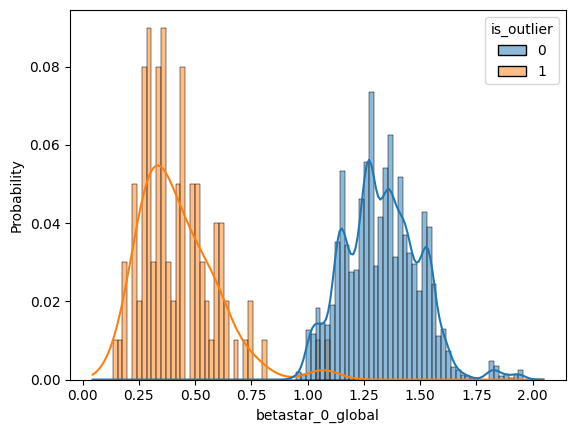

In [40]:
import seaborn as sns

x = global_structural_node_features.features_df.merge(features_df)
kwargs = dict(kde=True, stat='probability', kde_kws={'cut': 3})
sns.histplot(x, x='betastar_0_global',hue='is_outlier', **kwargs, common_norm=False)

<Axes: xlabel='emb_0_feat', ylabel='Probability'>

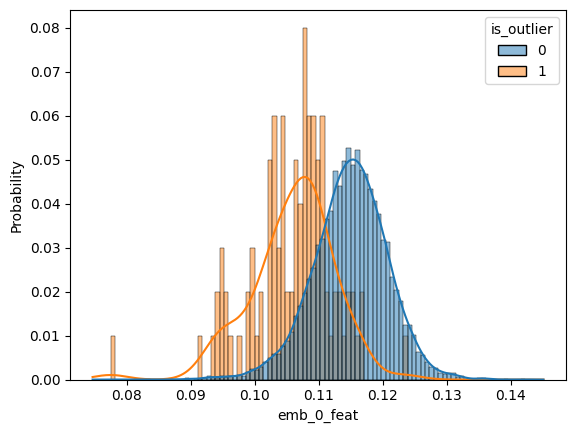

In [41]:
x = embeddings.embeddings_df.rename(columns={'graph_id': 'node_id'}).merge(features_df)
kwargs = dict(kde=True, stat='probability', kde_kws={'cut': 3})
sns.histplot(x, x='emb_0_feat',hue='is_outlier', **kwargs, common_norm=False)

In [42]:
dataset = GraphDataset(egonet_collection, embeddings)

In [43]:
from sklearn.ensemble import IsolationForest
import colorcet as cc
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import mlflow
import numpy as np
import seaborn as sns
import umap
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, precision_recall_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split


model_name, model = ("lr", LogisticRegression(max_iter=1000, random_state=13))
x_train, x_test, y_train, y_test = train_test_split(
    dataset.X_labeled,
    dataset.y_labeled,
    test_size=0.2,
    random_state=13,
    stratify=dataset.y_labeled,
)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred_prob = model.predict_proba(x_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
metrics = dict(
    accuracy_metric=accuracy_score(y_test, y_pred),
    auc_metric=roc_auc_score(y_test, y_pred_prob, average="micro", multi_class="ovr"),
    ap_metric=average_precision_score(y_test, y_pred_prob, average="micro"),
    f1_metric=f1_score(y_test, y_pred, average="micro"),
    aucpr=auc(recall, precision)
)
metrics

{'accuracy_metric': 0.99,
 'auc_metric': 0.874469696969697,
 'ap_metric': 0.09854902022623271,
 'f1_metric': 0.99,
 'aucpr': 0.08245742701436418}

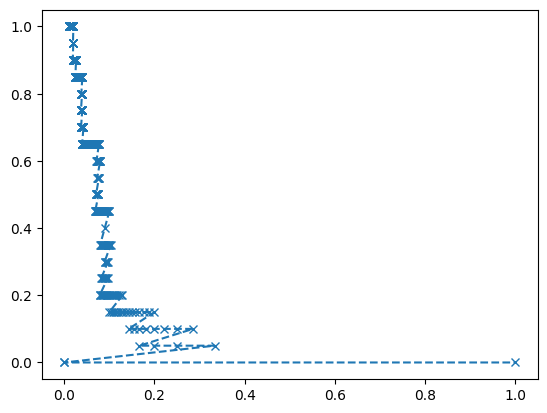

In [44]:
plt.plot(precision, recall, '--x')

In [45]:
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.metrics import make_scorer
scorer = make_scorer(roc_auc_score)
# scorer = make_scorer(f1_score, average='micro')

th_model = TunedThresholdClassifierCV(model, scoring=scorer)
X, y = x_train, y_train
# model.fit(X, y)
scorer(th_model.fit(X, y), X, y)

0.8026515151515151

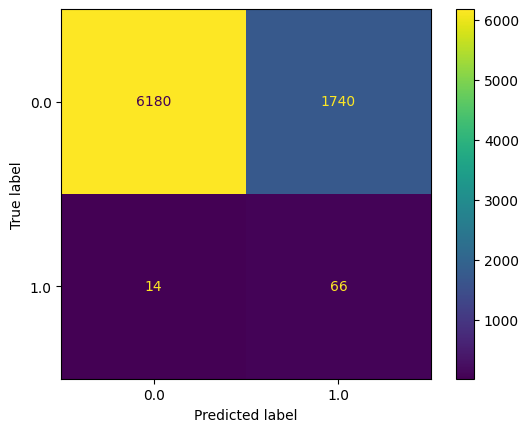

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(th_model, X, y)

In [47]:
metrics

{'accuracy_metric': 0.99,
 'auc_metric': 0.874469696969697,
 'ap_metric': 0.09854902022623271,
 'f1_metric': 0.99,
 'aucpr': 0.08245742701436418}